In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from hilbert import decode, encode

# General functions

In [2]:
def get_player_data(player_df, x_feat, y_feat):
    '''
        #param
            player_df: dataframe with player data
            
        #returns
            2-D array with shape [82,2]
    '''
    
    player_game_ids = list(player_df['game_id'])
    
    player_data = []
    
    for game_id in range(1,83):
        if game_id not in player_game_ids:
            player_data.append([0,0])
        else:
            player_game_id_x = player_df[player_df.game_id == game_id][x_feat].values[0]
            player_game_id_y = player_df[player_df.game_id == game_id][y_feat].values[0]
            player_game_id_data = [player_game_id_x, player_game_id_y]
            player_data.append(player_game_id_data)
        
    return np.array(player_data)

In [3]:
def zcurve(x,y):
    xx = x
    yy = y
    level = 0
    result = 0
    while xx > 0 or yy > 0:
        x_bit = 1 if (xx & 1) else 0
        y_bit = 1 if (yy & 1) else 0
        result += (x_bit + (y_bit << 1)) << (2*level)
        xx = xx >> 1
        yy = yy >> 1
        level += 1
    return result

def zcurve_inv(i):
    ii = i
    x = 0
    y = 0
    level = 0
    while ii > 0:
        x_bit = 1 if (ii & 1) else 0
        y_bit = 1 if (ii & 2) else 0
        x += x_bit << level
        y += y_bit << level
        level += 1
        ii = ii >> 2
    return (x,y)

In [4]:
def linterpolate(c0,c1,coef):
    return (c0 * (1-coef)) + (c1 * coef)

def binterpolate(c00,c10,c01,c11,coef_x,coef_y):
    c_bottom = linterpolate(c00,c10,coef_x)
    c_top    = linterpolate(c01,c11,coef_x)
    
    return linterpolate(c_bottom,c_top,coef_y)

def get_color_from_coords(x,y):
    c00, c10, c01, c11 = np.array([0,0,0]),np.array([0,0,1]),np.array([1,1,0]),np.array([0,1,0])
    
    x_max = 30.0
    y_max = 10.0
    
    return binterpolate(c00,c10,c01,c11,min(x/x_max, 1),min(y/y_max,1))

def get_color_from_ncoords(x,y):
    c00, c10, c01, c11 = np.array([0,0,0]),np.array([0,0,1]),np.array([1,1,0]),np.array([0,1,0])
    
    return binterpolate(c00,c10,c01,c11,x,y)

def build_rug(data_matrix, max_x, max_y):
    clist = []
    
    for i in range(data_matrix.shape[0]):
        aux = []
        for j in range(data_matrix.shape[1]):
            norm_x = min(data_matrix[i][j][0]/max_x, 1)
            norm_y = min(data_matrix[i][j][1]/max_y, 1)
            aux.append(get_color_from_ncoords(norm_x,norm_y))
            
        clist.append(aux)
        
    return clist

def sort_matrix_rows(matrix, reverse=False, by=['lex','max','min','sum','x','y','z-curve','hilbert']):
    if by == 'lex':
        return np.array([sorted(element, key=lambda x: (x[0],x[1]), reverse=reverse) for element in matrix])
    elif by == 'max':
        return np.array([sorted(element, key=lambda x: max(x), reverse=reverse) for element in matrix])
    elif by == 'min':
        return np.array([sorted(element, key=lambda x: min(x), reverse=reverse) for element in matrix])
    elif by == 'sum':
        return np.array([sorted(element, key=lambda x: sum(x), reverse=reverse) for element in matrix])
    elif by == 'x':
        return np.array([sorted(element, key=lambda x: x[0], reverse=reverse) for element in matrix])
    elif by == 'y':
        return np.array([sorted(element, key=lambda x: x[1], reverse=reverse) for element in matrix])
    elif by == 'z-curve':
        return np.array([sorted(element, key=lambda x: zcurve(x[0],x[1]), reverse=reverse) for element in matrix])
    elif by == 'hilbert':
        return np.array([sorted(element, key=lambda x: encode(np.array([x[0],x[1]]),2,7), reverse=reverse) for element in matrix])
    
def sort_matrix_columns(matrix, reverse=True):
    tmatrix = matrix.transpose((1,0,2))
    stmatrix = sort_matrix_rows(tmatrix, reverse=reverse)
    return stmatrix.transpose((1,0,2))

In [5]:
def plot_coordinates(data_matrix):
    fig, ax = plt.subplots(3,1,figsize=(20,12))

    for obj in data_matrix:    
        ax[0].plot(obj[:,0], obj[:,1], marker='o')
        ax[1].plot(range(len(obj)), obj[:,0])
        ax[2].plot(range(len(obj)), obj[:,1])
        
    plt.show()

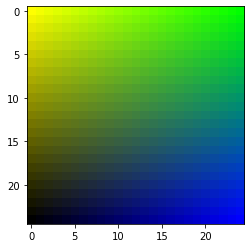

In [6]:
a = np.zeros([25,25,3])

for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        a[24-i][j] = get_color_from_ncoords(j/24.0, i/24.0)
plt.imshow(a)

The above image represents the colormap used in the following rugs:

* black  &rarr; low x // low y
* yellow &rarr; low x // high y
* green  &rarr; high x // high y
* blue   &rarr; high x // lowy

In [8]:
def build_player_matrix(data_path, x_feat, y_feat, team=None, min_gp=0):
    '''
        data_path: path containing elements data
    '''
    player_matrix = []
    player_names  = []
    
    for fname in os.listdir(data_path):
        player_df = pd.read_csv(data_path+'/'+fname, sep='|')
        
        if player_df.shape[0] < min_gp:
            continue

        if team:
            if team not in player_df.team.values: continue
        
        player_names.append(fname)
        player_data = get_player_data(player_df, x_feat, y_feat)
        
        player_matrix.append(player_data)
    
    player_matrix = np.array(player_matrix)   
    
    return player_matrix,player_names

### [Sorting matrix rows by different methods](#matrix_sort)
### [Glyph matrix](#glyph_matrix)

# Creating rugs for NBA data

In [7]:
x = 'points'
y = 'assists'

In the following examples we'll be using the x and y axis to represent points and assists of a given player, respectively.

## Creating player rugs

 * Each row is a player and each column is a game_id

In [8]:
pmatrix, pnames = build_player_matrix(r'../../data/NBA/nba_1516/nba_players_1516', x, y)
players_1516 = build_rug(pmatrix, 30.0, 10.0)

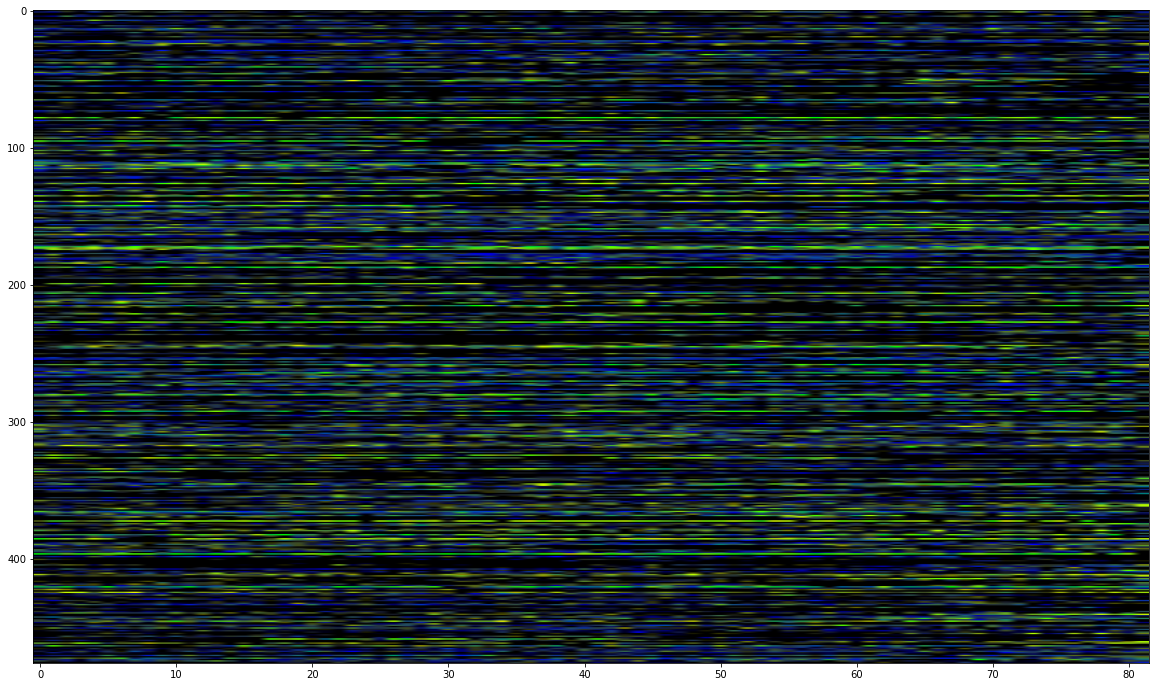

In [10]:
plt.figure(figsize=(20,12))
plt.imshow(players_1516, aspect='auto')
plt.show()

In the above rug each row represents a player and each column represents a game_id. There's not a clear pattern to be extracted from the image other than some players that have a consistently high number of points and assists (green rows), especially one near the "400" tick. Other interesting thing that can be noted is that a player near the "300" tick alternates between high points, high assists games and high points, low assists.

We can sort the rows of the rug to try and clear some of the visual clutter, as we can see below. We'll sort the rows according to the sum of its values.

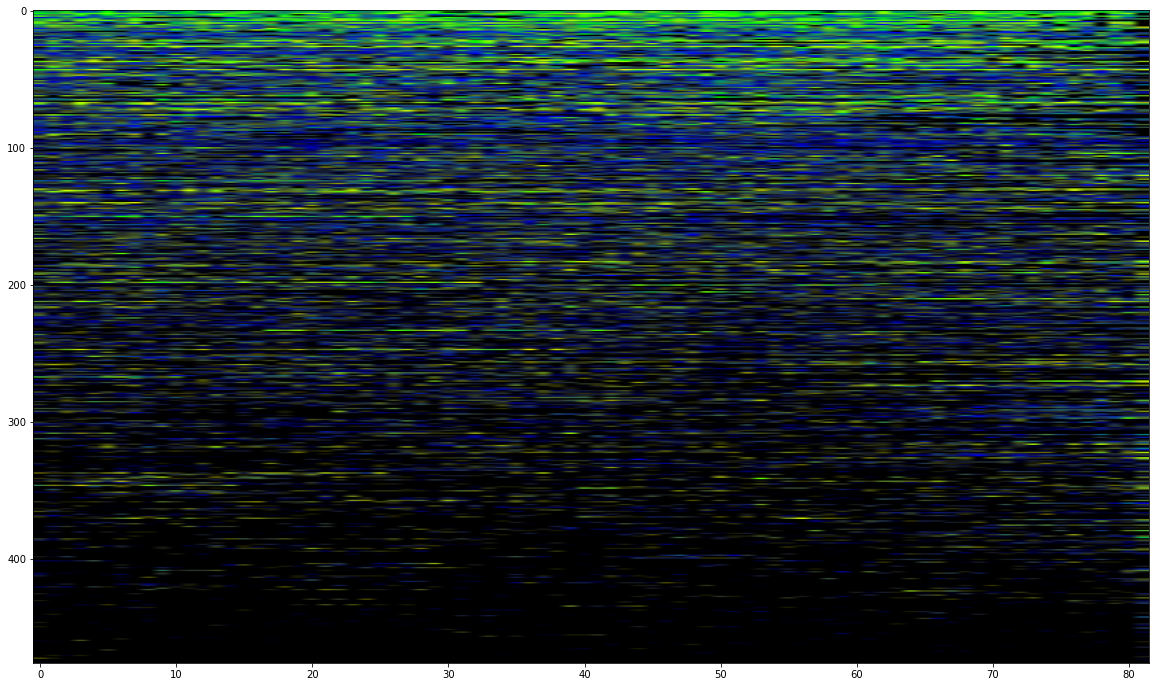

In [11]:
spmatrix = np.array(sorted(pmatrix, key=lambda x: np.sum(x), reverse=True))
sorted_players_1516 = build_rug(spmatrix, 30.0, 10.0)

plt.figure(figsize=(20,12))
plt.imshow(sorted_players_1516, aspect='auto')
plt.show()

We can try to compare the rugs of two seasons to have some insight about what happened. We'll use as example the 15/16 season and the 95/96 season.

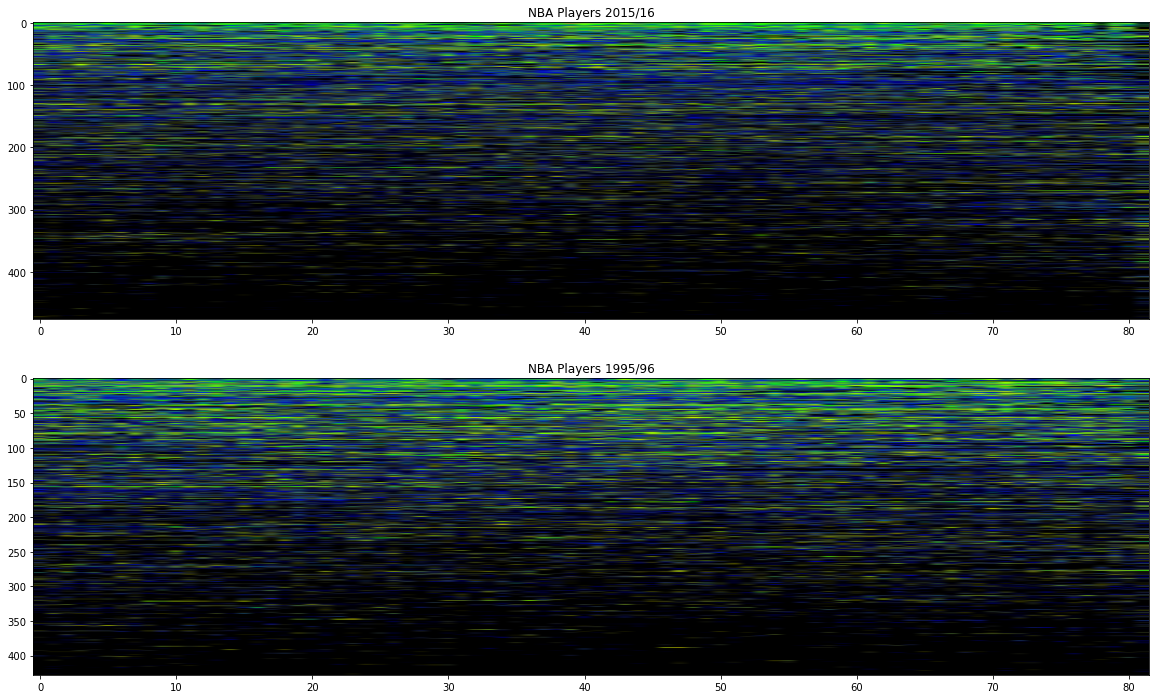

In [12]:
pmatrix_9596, pnames_9596 = build_player_matrix(r'../../data/NBA/nba_9596/nba_players_9596',x,y)
players_9596 = build_rug(pmatrix_9596, 30.0, 10.0)

spmatrix_9596 = np.array(sorted(pmatrix_9596, key=lambda x: np.sum(x), reverse=True))
sorted_players_9596 = build_rug(spmatrix_9596, 30.0, 10.0)

f, axs = plt.subplots(2,1,figsize=(20,12))

axs[0].imshow(sorted_players_1516, aspect='auto')
axs[0].set_title('NBA Players 2015/16')

axs[1].imshow(sorted_players_9596, aspect='auto')
axs[1].set_title('NBA Players 1995/96')

plt.show()

Comparing the two rugs above we can see that they behave similarly, there are some players that regularly have high points and high assists. One difference between the rugs is that the 15/16 rugs has more players that consistently have high points/low assists, denoted by blue regions on the rug. While the 95/96 rug has a larger region of green/yellow players.

## Creating All-Star rugs

* It's the same than the section before, but now we'll create the rugs of the all star players of each season

In [13]:
# Creating matrixes and rug for 15/16 all stars
as_matrix_1516,as_names_1516 = build_player_matrix(r'../../data/NBA/nba_1516/nba_allstar_1516',x,y)

# as_sorted_1516 = np.array(sorted(as_matrix_1516, key=lambda x: np.sum(x), reverse=True))
sorted_allstars_1516 = build_rug(as_matrix_1516, 30.0, 10.0)


#Creating matrixes and rug for 95/96 all stars
as_matrix_9596, as_names_9596 = build_player_matrix(r'../../data/NBA/nba_9596/nba_allstar_9596',x,y)

# as_sorted_9596 = np.array(sorted(as_matrix_9596, key=lambda x: np.sum(x), reverse=True))
sorted_allstars_9596 = build_rug(as_matrix_9596, 30.0, 10.0)

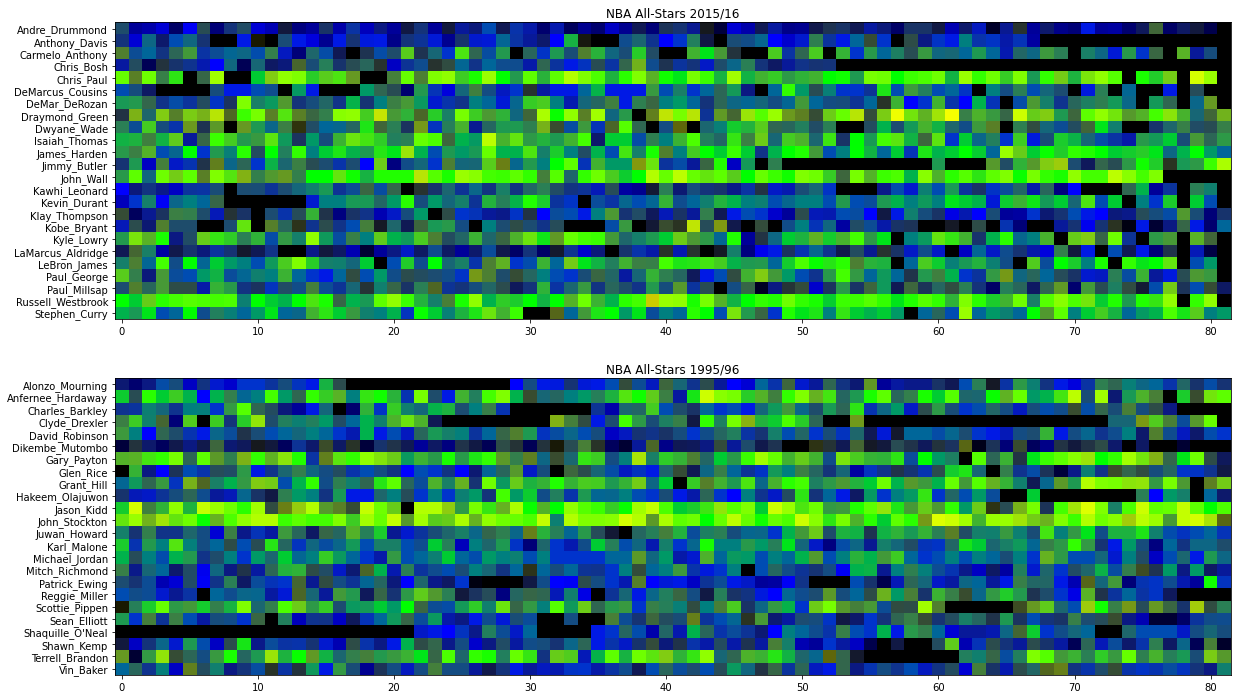

In [14]:
f, axs = plt.subplots(2,1,figsize=(20,12))

axs[0].imshow(sorted_allstars_1516, aspect='auto')
axs[0].set_title('NBA All-Stars 2015/16')
axs[0].set_yticks(range(len(as_names_1516)))
axs[0].set_yticklabels(as_names_1516)

axs[1].imshow(sorted_allstars_9596, aspect='auto')
axs[1].set_title('NBA All-Stars 1995/96')
axs[1].set_yticks(range(len(as_names_9596)))
axs[1].set_yticklabels(as_names_9596)

plt.show()

The rugs are very similar, meaning that in respect to points and assists the behaviour of the NBA All-Stars is very close even 20 years apart. All-Stars tend to be players that have a high number of points and some of them also have a high number of assists, but others don't. It's also possible to see that some All Stars in the 95/96 season missed a large amount of games during the season, like David Robinson (who missed a lot of games after the all star game) and Shaquille O'Neal who missed the first 21 games of the season. Another interesting pattern is that some of the All Stars of 2015/16 missed some games in the end of the season, this probably was due to load management of players who were going to the playoffs.

## Comparing two super teams

In [15]:
bulls_9596, nbulls_9596 = build_player_matrix(r'../../data/NBA/nba_9596/nba_players_9596',x,y,'Team.CHICAGO_BULLS')
bulls_9596_rug = build_rug(bulls_9596, 30.0, 10.0)

warriors_1516, nwarriors_1516 = build_player_matrix(r'../../data/NBA/nba_1516/nba_players_1516',x,y,'Team.GOLDEN_STATE_WARRIORS')
warriors_1516_rug = build_rug(warriors_1516, 30.0, 10.0)

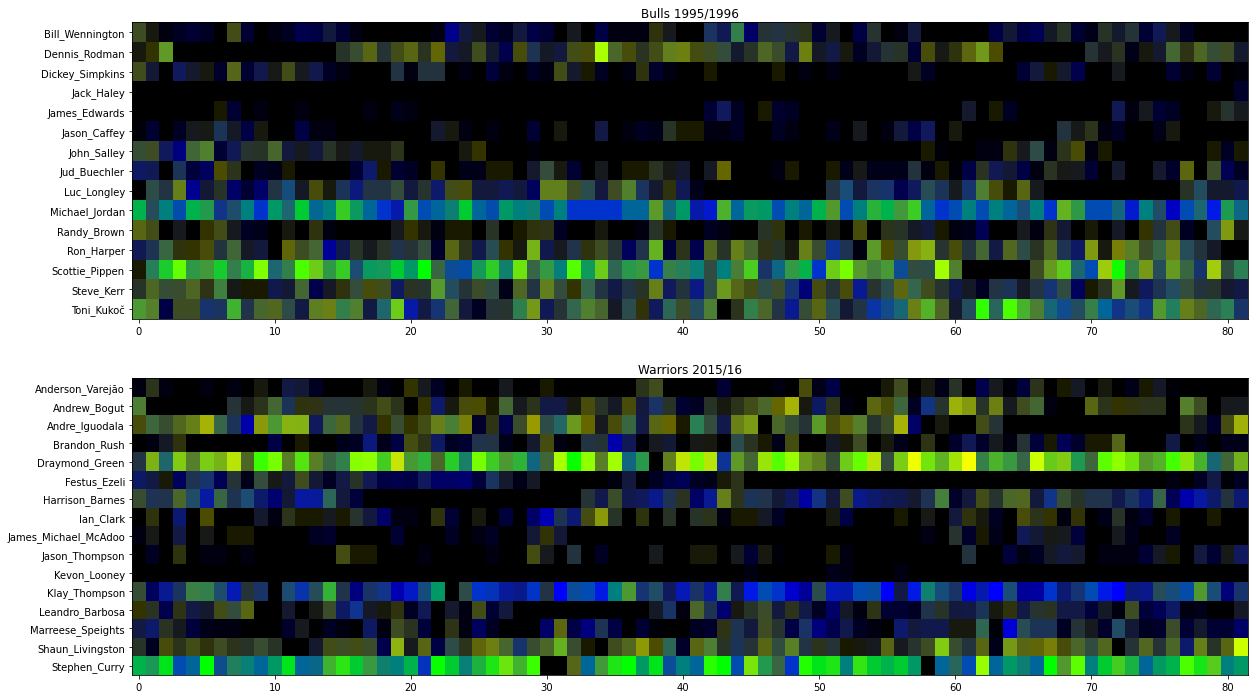

In [16]:
f, axs = plt.subplots(2,1,figsize=(20,12))

axs[0].imshow(bulls_9596_rug, aspect='auto')
axs[0].set_title('Bulls 1995/1996')
axs[0].set_yticks(range(len(nbulls_9596)))
axs[0].set_yticklabels(nbulls_9596)

axs[1].imshow(warriors_1516_rug, aspect='auto')
axs[1].set_title('Warriors 2015/16')
axs[1].set_yticks(range(len(nwarriors_1516)))
axs[1].set_yticklabels(nwarriors_1516)

plt.show()

### 15/16 Warriors 

The Warriors had a pure point-scorer in Klay Thompson, evidenced by the mainly blue tones in his row. The green squares in his row show that Stephen Curry is a player that often has high-point high-assist games but also high-point low-assist games, it's possible to see some black squares in his row denoting what probably are missed games (due to injury or load management). Another interesting player is Draymond Green, who missed very few games and contributed with the team with points and assists, but some days he had a bigger contribution in the assist front.

### 95/96 Bulls

It's easy to see that Michael Jordan was running the show with the Bulls in 95/96, switching between high-point high-assist games and high-point games. Scottie Pippen was a very good support character showing his versatility with high-points high-assists games, but he missed some games in a row near game \#60, maybe if he was healthy the Bulls would still have the best season. Other than that some player contributed with points and assists in specific points in the season, like Toni Kukoc who stepped up his game in Scottie Pippen's absence.

## The 3-point shot

For the following analysis we will consider the attempted three point fgs as x and made three point fgs as y

In [40]:
x = 'attempted_three_point_field_goals'
y = 'made_three_point_field_goals'

### Comparing the three-point shot in different eras

Comparing the two rugs we can see that the in the 15/16 season there's more blue regions in the rug, meaning that there have been more players with a high number of attempted 3p fgs. We filtered the number of players considered to players that played at least 30 games in the season

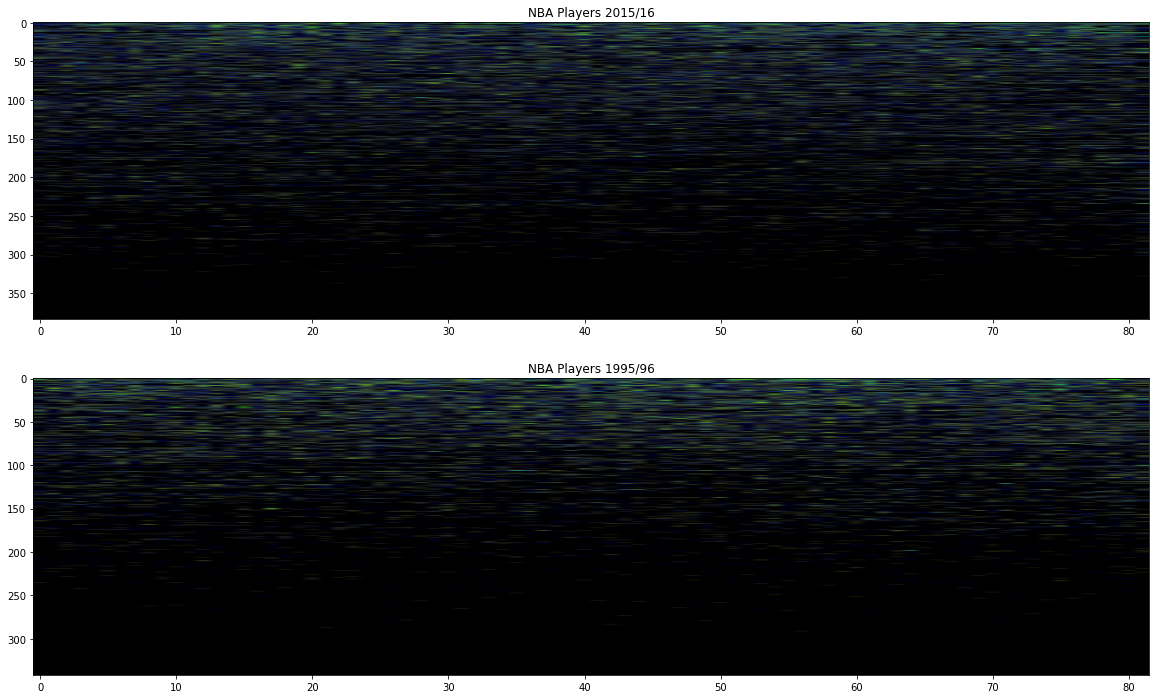

In [41]:
tp_matrix_9596, tp_names_9596 = build_player_matrix(r'../../data/NBA/nba_9596/nba_players_9596',x,y,min_gp=30)
s_tp_matrix_9596 = np.array(sorted(tp_matrix_9596, key=lambda x: np.sum(x), reverse=True))
max_x_9596 = np.max(tp_matrix_9596[:,:,0])
max_y_9596 = np.max(tp_matrix_9596[:,:,1])
s_tp_rug_9596 = build_rug(s_tp_matrix_9596, max_x_9596, max_y_9596)

tp_matrix_1516, tp_names_1516 = build_player_matrix(r'../../data/NBA/nba_1516/nba_players_1516',x,y,min_gp=30)
s_tp_matrix_1516 = np.array(sorted(tp_matrix_1516, key=lambda x: np.sum(x), reverse=True))
max_x_1516 = np.max(tp_matrix_1516[:,:,0])
max_y_1516 = np.max(tp_matrix_1516[:,:,1])
s_tp_rug_1516 = build_rug(s_tp_matrix_1516, max_x_1516, max_y_1516)

f, axs = plt.subplots(2,1,figsize=(20,12))

axs[0].imshow(s_tp_rug_1516, aspect='auto')
axs[0].set_title('NBA Players 2015/16')

axs[1].imshow(s_tp_rug_9596, aspect='auto')
axs[1].set_title('NBA Players 1995/96')

plt.show()

### Comparing super teams' three point shot

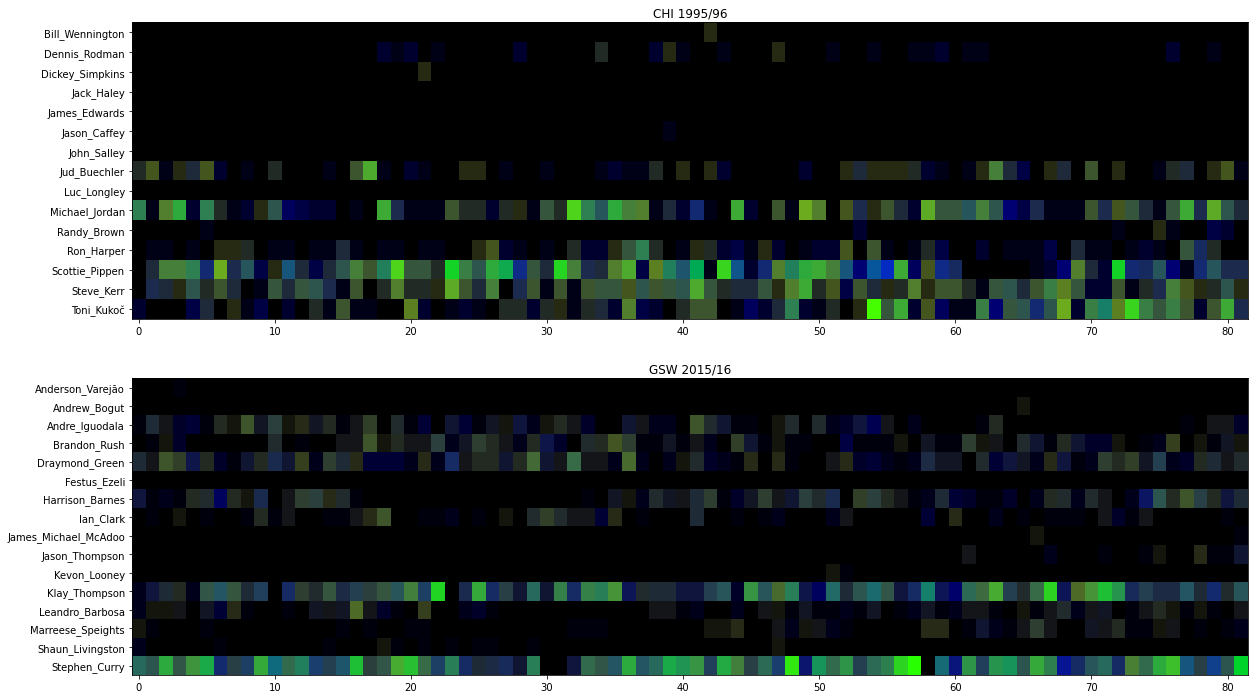

In [42]:
chi_9596, chi_names_9596 = build_player_matrix(r'../../data/NBA/nba_9596/nba_players_9596',x,y,'Team.CHICAGO_BULLS')
chi_max_x_9596 = np.max(chi_9596[:,:,0])
chi_max_y_9596 = np.max(chi_9596[:,:,1])
chi_rug_9596 = build_rug(chi_9596, chi_max_x_9596, chi_max_y_9596)

gsw_1516, gsw_names_1516 = build_player_matrix(r'../../data/NBA/nba_1516/nba_players_1516',x,y,'Team.GOLDEN_STATE_WARRIORS')
gsw_max_x_1516 = np.max(gsw_1516[:,:,0])
gsw_max_y_1516 = np.max(gsw_1516[:,:,1])
gsw_rug_1516 = build_rug(gsw_1516, gsw_max_x_1516, gsw_max_y_1516)

f, axs = plt.subplots(2,1,figsize=(20,12))

axs[1].imshow(gsw_rug_1516, aspect='auto')
axs[1].set_title('GSW 2015/16')
axs[1].set_yticks(range(len(gsw_names_1516)))
axs[1].set_yticklabels(gsw_names_1516)

axs[0].imshow(chi_rug_9596, aspect='auto')
axs[0].set_title('CHI 1995/96')
axs[0].set_yticks(range(len(chi_names_9596)))
axs[0].set_yticklabels(chi_names_9596)

plt.show()

## to-do

* Plot x, y connecting the dots
* Games not played/bad games on descriptions
* Compare few players in closer seasons
* Analyze 3-pointers (2015/16 and 1995/96)
* Compare 95/96 Bulls and 15/16 Warriors (filter matrix to teams' players)
* Write when all star game happened (in all star rugs) and observe patterns pre/post asg

# Creating COVID data rugs

In [25]:
from datetime import datetime
from datetime import date
import matplotlib.dates as mdates

In [26]:
def get_location_data_from_df(df):
    '''
        df: location dataframe;
    '''
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    all_dates = pd.date_range(start="2020-01-22",end="2021-07-17")
    location_dates = list(df['date'])
    location_data = []
    
    for date in all_dates:
        if date not in location_dates:
            location_data.append([0,0])
        else:
            location_date_ncspm = int(df[df.date == date]['new_cases_smoothed_per_million'].values[0])
            if location_date_ncspm < 0:
                location_date_ncspm = 0
            location_date_ndspm = int(df[df.date == date]['new_deaths_smoothed_per_million'].values[0])
            location_data.append([location_date_ncspm, location_date_ndspm])
        
    return np.array(location_data)

def build_locations_matrix(data_path, continent=None, step=None):
    '''
        data_path: path containing elements data
        continent: select specific continent to filter data
    '''
    loc_matrix = []
    loc_names  = []
    for fname in os.listdir(data_path):
        
        loc_df = pd.read_csv(data_path+'/'+fname)
        if continent:
            if loc_df.continent.values[0] != continent: continue
            
        loc_names.append(fname)
        loc_data = get_location_data_from_df(loc_df)
        
        loc_matrix.append(loc_data)
    
    loc_matrix = np.array(loc_matrix)
    
    if step:
        loc_matrix = loc_matrix[:,range(0,loc_matrix.shape[1],step),:]
        
    return loc_matrix, loc_names

In [27]:
lmatrix, lnames = build_locations_matrix(r'../data/COVID/locations_filtered')

max_x = np.max(lmatrix[:,:,0])
max_y = np.max(lmatrix[:,:,1])

lrug    = build_rug(lmatrix, max_x, max_y)

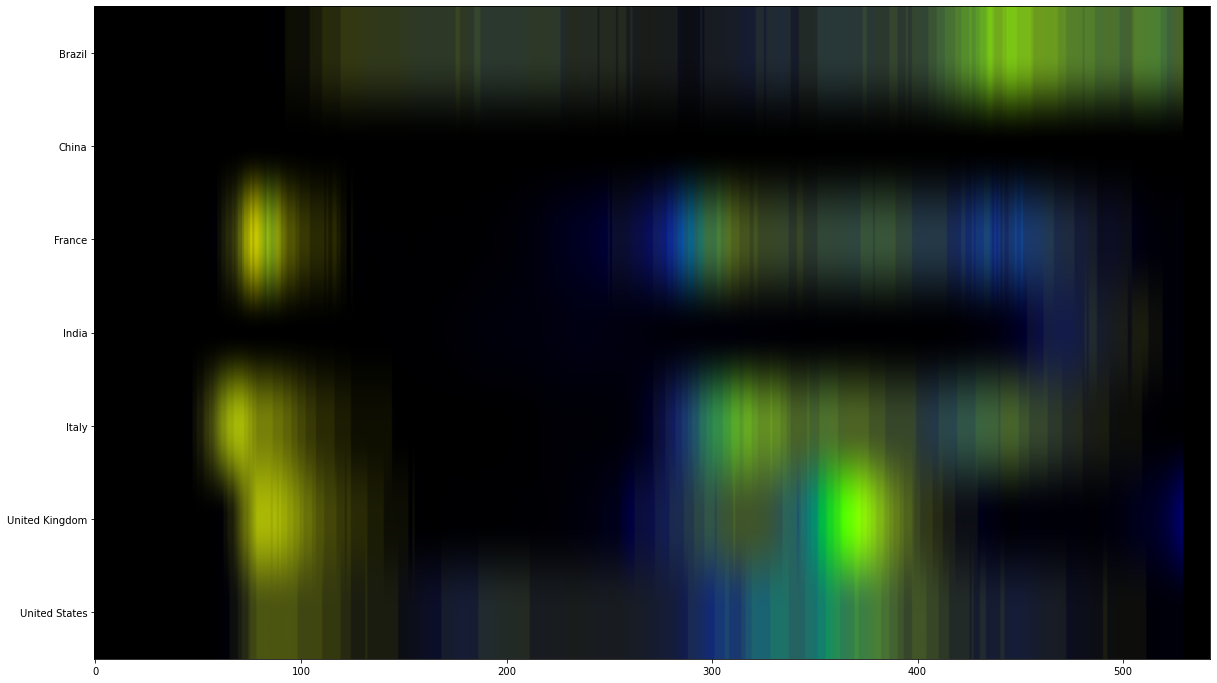

In [28]:
plt.figure(figsize=(20,12))
plt.imshow(lrug, aspect='auto')
plt.yticks(range(7), labels=lnames)
plt.show()

In the above plot the rows represent 6 filtered countries and columns are a specific date. To get the color the X coordinate is cases smoothed per million and the Y coordinate is deaths smoothed per million.

Looking at the plot we can see that in some countries (specially in UK) there has been a surge of blue cells, denoting a high number of cases smoothed per million and low number of deaths smoothed per million, that can represent the new variant delta that has been spreading but is not lethal because of the vaccines.

## G20 rug

We'll use the same settings as before but using 19 the countries that are part of the G20 group (European Union is a member but it's not considered in this case)

In [29]:
g20_matrix, g20_names = build_locations_matrix(r'../data/COVID/g20')

max_x = np.max(lmatrix[:,:,0])
max_y = np.max(lmatrix[:,:,1])

g20_rug    = build_rug(g20_matrix, max_x, max_y)

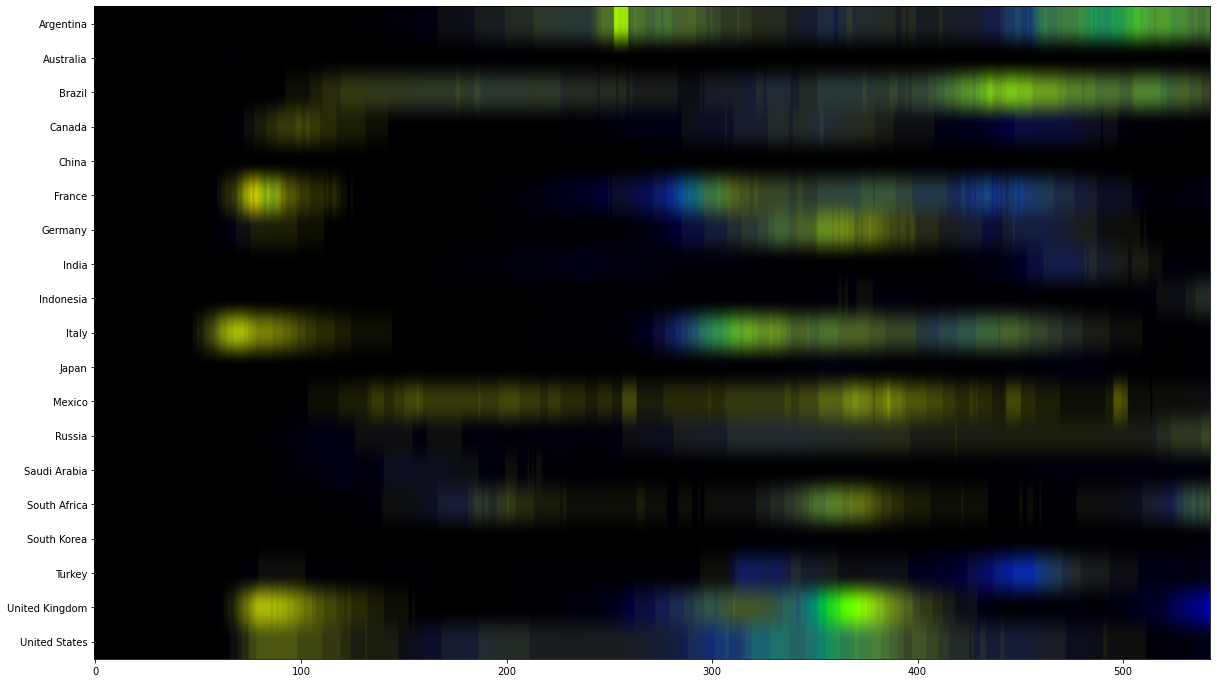

In [30]:
plt.figure(figsize=(20,12))
plt.imshow(g20_rug, aspect='auto')
plt.yticks(range(19), labels=g20_names)
plt.show()

An interesting pattern can be found in this image observing Canada, France, Germany, Italy, UK and US: two separated "outbreaks" one around day 100 (after jan 22, 2020) and other starting between day 250 and 300. Brazil and Argentina are still having a hard time with COVID-19. Meanwhile in India the size of the population might be masking patterns since we're using 'per million' stats

## Regions rug

In [31]:
regions_matrix, rnames = build_locations_matrix(r'../data/COVID/regions')

max_x = np.max(regions_matrix[:,:,0])
max_y = np.max(regions_matrix[:,:,1])

regions_rug    = build_rug(regions_matrix, max_x, max_y)

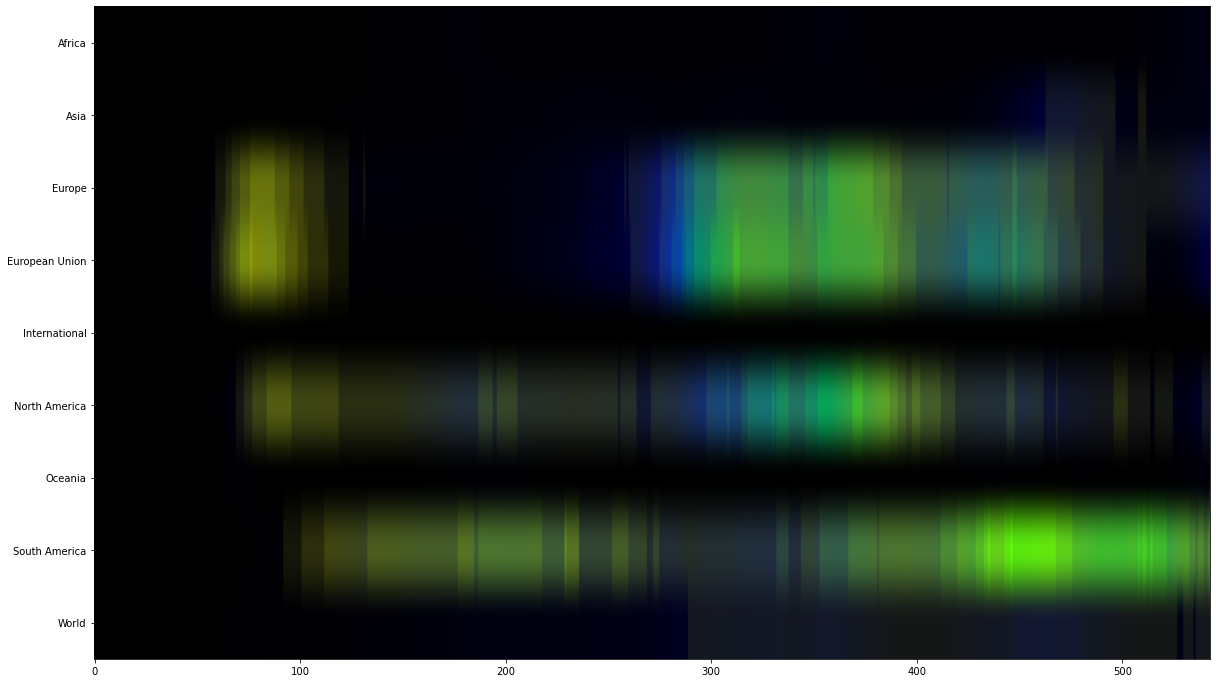

In [32]:
plt.figure(figsize=(20,12))
plt.imshow(regions_rug, aspect='auto')
plt.yticks(range(9),labels=rnames)
plt.show()

We can observe in the plot above that the region of South America has a different behaviour than the others, with yellow/green regions in the most recent dates, that means that there is still a high number of deaths smoothed per million, the reason behind it can be the delay in vaccination in some countries. The rows of Europe and European Union are very similar and have a recent surge of blue regions, maybe with the same cause as mentioned before, this also happens in North America. Asia has mostly black regions with some touches of blue towards the end. Meanwhile Africa doesn't seem to have any interesting patterns (the fact that it has pretty much no colors may be due to missing data).

### Exploring South America

In [33]:
south_am_matrix, south_am_names = build_locations_matrix(r'../data/COVID/locations', continent='South America')

south_am_maxx = np.max(south_am_matrix[:,:,0])
south_am_maxy = np.max(south_am_matrix[:,:,1])

south_am_rug  = build_rug(south_am_matrix, south_am_maxx, south_am_maxy)

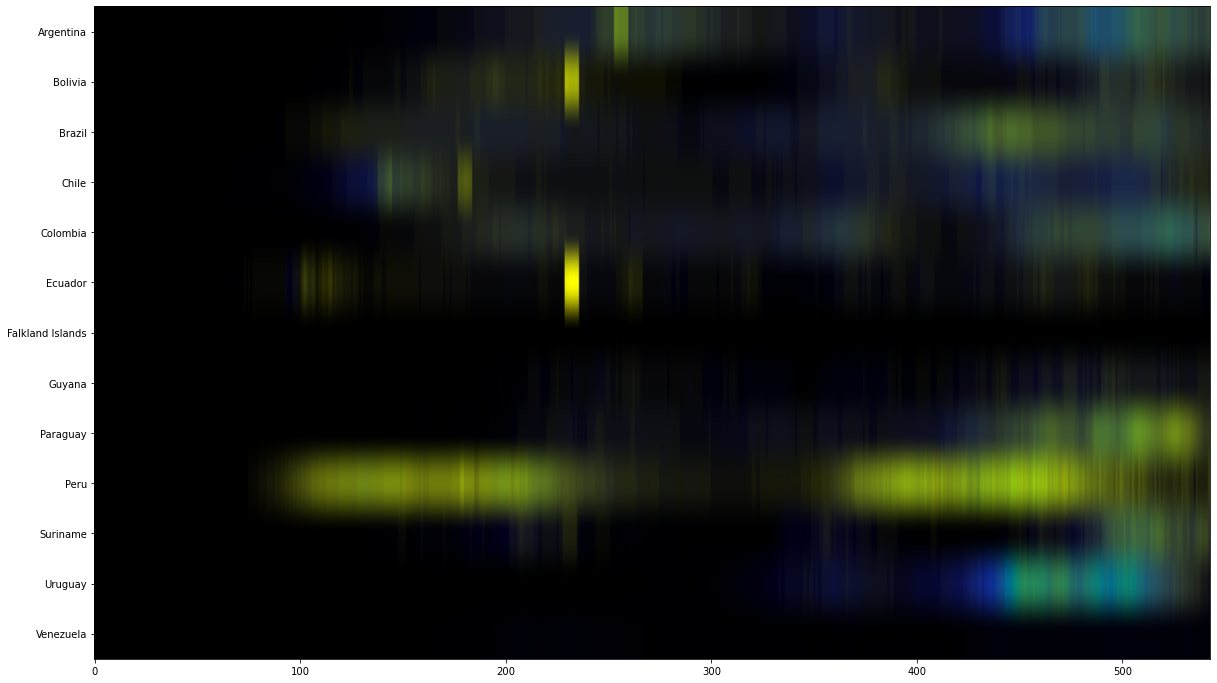

In [34]:
plt.figure(figsize=(20,12))
plt.imshow(south_am_rug, aspect='auto')
plt.yticks(range(len(south_am_names)),labels=south_am_names)
plt.show()

Analyzing the above plot, we can see that many countries in South America still suffer with the effects of COVID-19, specially Peru, that had a high number of deaths smoothed per million in two different time intervals. Other interesting find is that Uruguay wasn't very affected by the pandemic until recently, Suriname and Paraguay seem to be heading in the same direction. Also Ecuador and Bolivia had a very specific time frame with high mortality about the same time.

## Downsampling x axis

For resolution purposes it might be beneficial to downsample the x axis, so we explore this by having an offset of 7 days from the starting day of 2020-01-22, Wednesday.

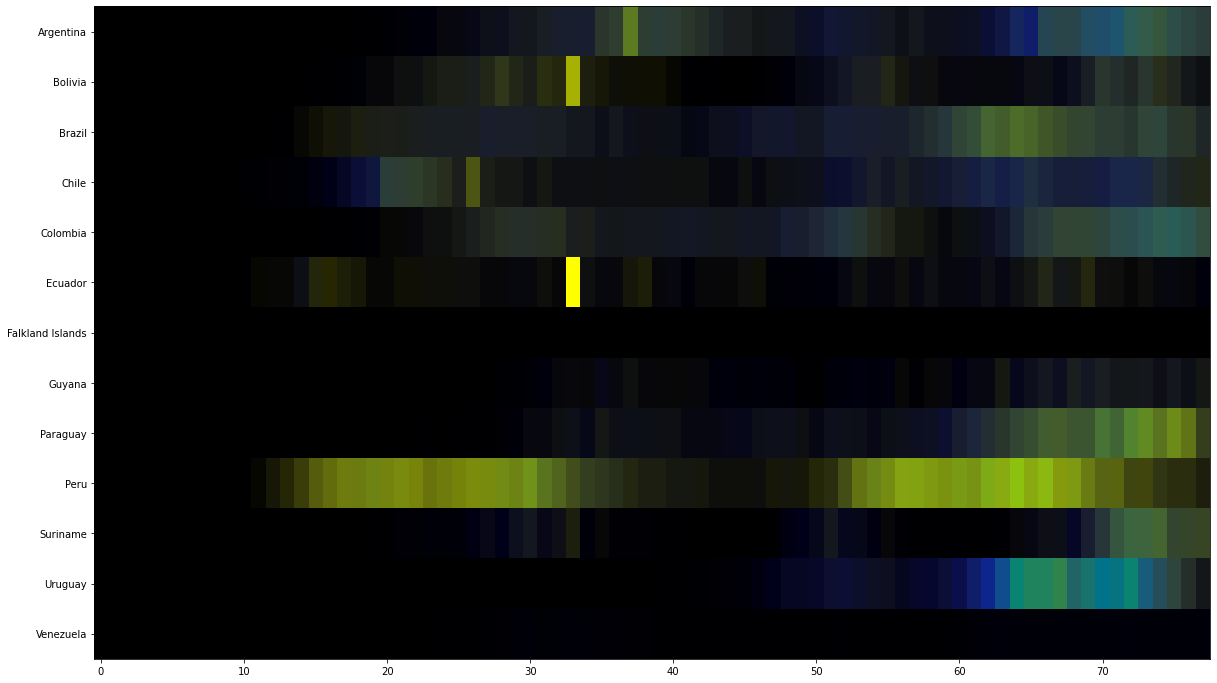

In [44]:
offseted_sa, offseted_sa_names = build_locations_matrix(r'../data/COVID/locations', continent='South America', step=7)

offseted_sa_x = np.max(offseted_sa[:,:,0])
offseted_sa_y = np.max(offseted_sa[:,:,1])

offseted_sa_rug  = build_rug(offseted_sa, offseted_sa_x, offseted_sa_y)

plt.figure(figsize=(20,12))
plt.imshow(offseted_sa_rug, aspect='auto')
plt.yticks(range(len(offseted_sa_names)),labels=offseted_sa_names)
plt.show()

## to-do

* Change colormap to use a fixed amount of colors instead of interpolate
* Change from day to week (test) (e.g., get 7 day offsets) (downsampling)


### Sorting rows of a rug

In some cases, there are negative values of cases (x) (I don't know why) that's why some cells with high death (y) count are being put at the beggining of the rows/columns. (UPDATE: Changed negative values to 0, can comment if needed)

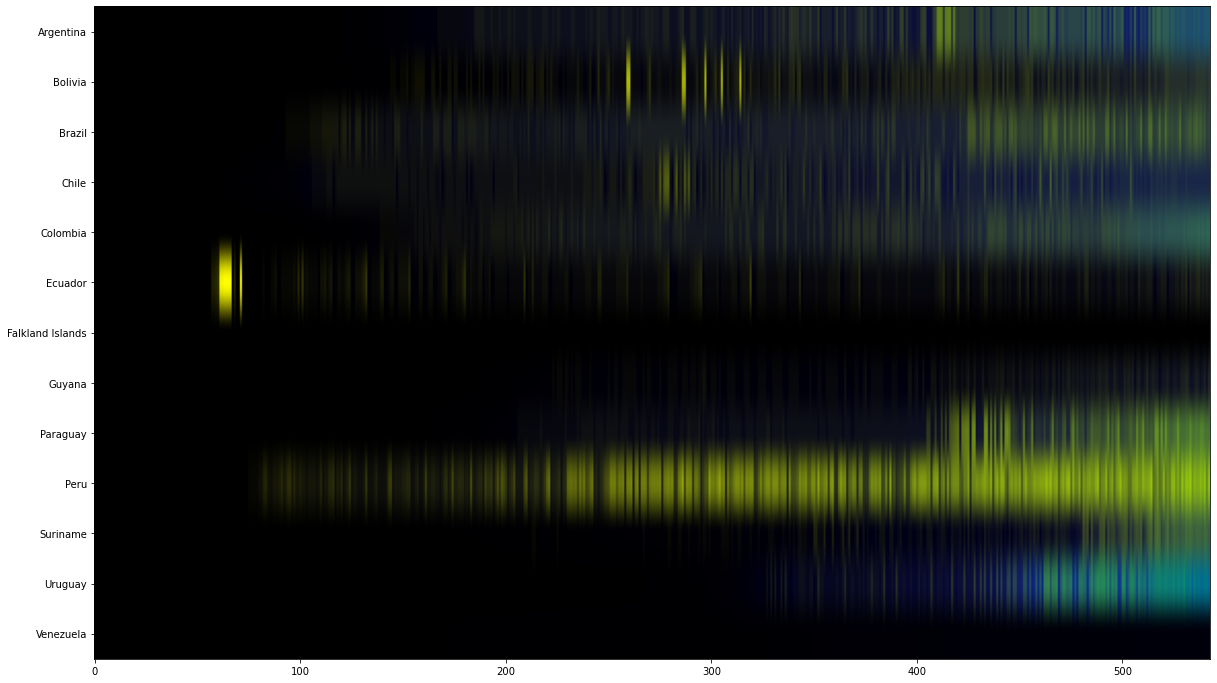

In [36]:
rsorted_samatrix = sort_matrix_rows(south_am_matrix)
rsorted_sarug = build_rug(rsorted_samatrix, south_am_maxx, south_am_maxy)

plt.figure(figsize=(20,12))
plt.imshow(rsorted_sarug, aspect='auto')
plt.yticks(range(len(south_am_names)),labels=south_am_names)
plt.show()

In the above rug, its rows are sorted in ascendent order first by its cases (x) value, then by deaths (y) value. That explains why some cells with a strong yellow (high y) appear in the beggining of the row, the values in the x domain are, by nature, higher than in the y domain so a low x might still be higher than a high y.

### Sorting columns of a rug

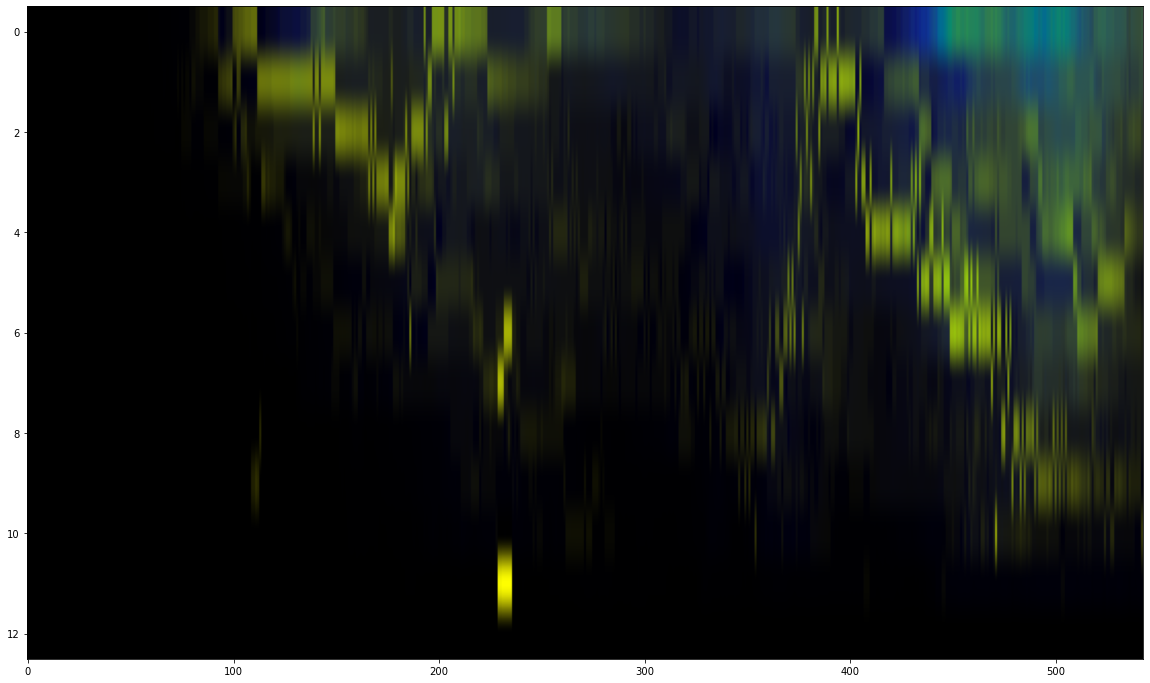

In [37]:
csorted_samatrix = sort_matrix_columns(south_am_matrix)
csorted_sarug = build_rug(csorted_samatrix, south_am_maxx, south_am_maxy)

plt.figure(figsize=(20,12))
plt.imshow(csorted_sarug, aspect='auto')
plt.show()

### Combining sorts

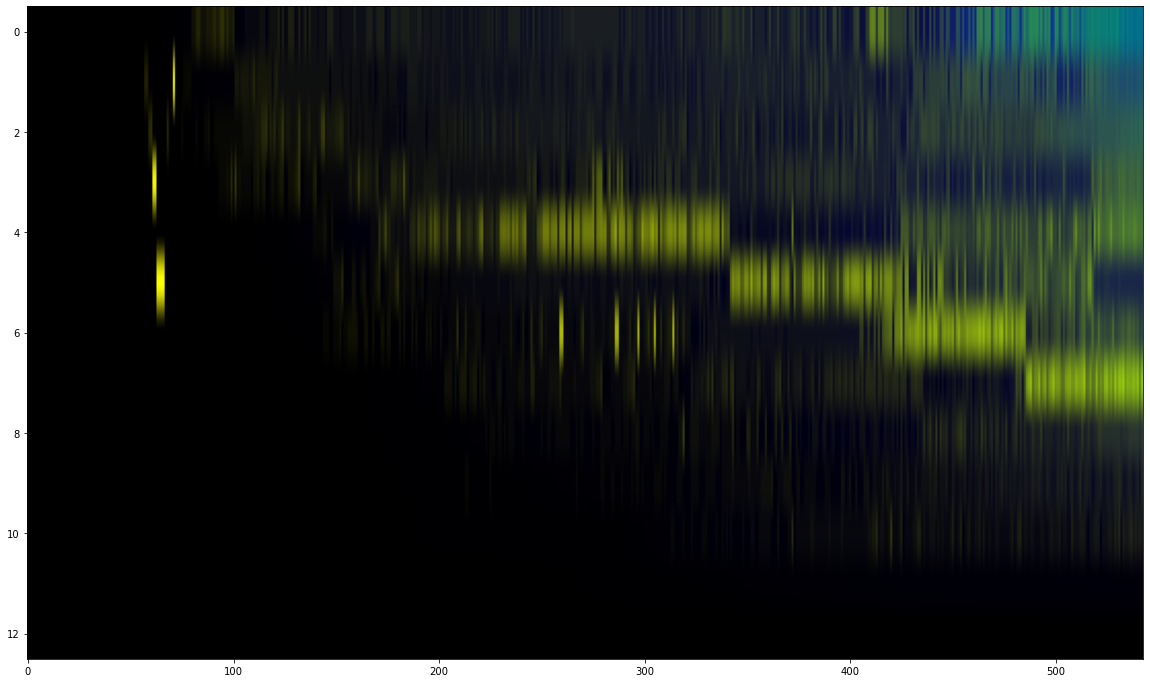

In [38]:
sorted_samatrix = sort_matrix_columns(sort_matrix_rows(south_am_matrix))
sorted_sarug = build_rug(sorted_samatrix, south_am_maxx, south_am_maxy)

plt.figure(figsize=(20,12))
plt.imshow(sorted_sarug, aspect='auto')
plt.show()

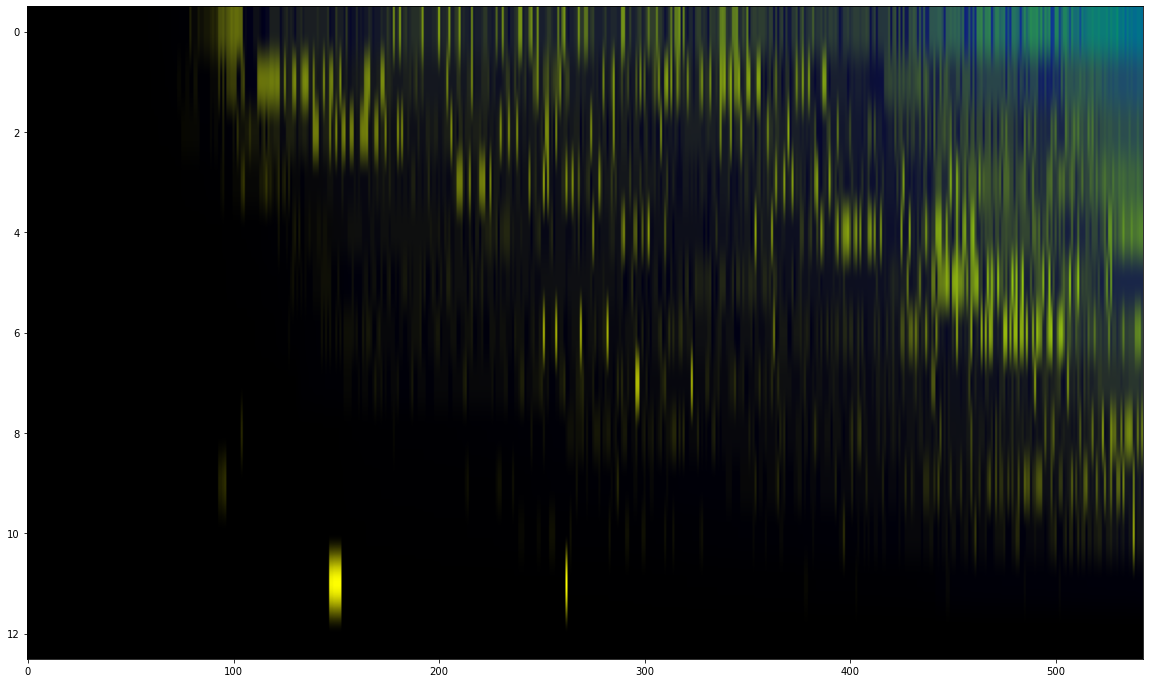

In [39]:
sorted_samatrix_ = sort_matrix_rows(sort_matrix_columns(south_am_matrix))
sorted_sarug_ = build_rug(sorted_samatrix_, south_am_maxx, south_am_maxy)

plt.figure(figsize=(20,12))
plt.imshow(sorted_sarug_, aspect='auto')
plt.show()

<a id='matrix_sort'></a>
# Sorting matrix rows by different methods

In [9]:
def plot_rug(rug, names, ax=None, title=None):
    if ax:
        ax.imshow(rug, aspect='auto')
        ax.set_yticks(range(len(names)))
        ax.set_yticklabels(names)
        if title:
            ax.set_title(title)
    else:
        plt.figure(figsize=(20,12))
        plt.imshow(rug, aspect='auto')
        plt.yticks(range(len(names)),labels=names)
        plt.show()

In [10]:
x = 'points'
y = 'assists'
test_matrix, test_names = build_player_matrix(r'../../data/NBA/test_matrix', x, y)

# sorting matrix rows by different methods
lex_matrix     = sort_matrix_rows(test_matrix, by='lex')
max_matrix     = sort_matrix_rows(test_matrix, by='max')
min_matrix     = sort_matrix_rows(test_matrix, by='min')
sum_matrix     = sort_matrix_rows(test_matrix, by='sum')
x_matrix       = sort_matrix_rows(test_matrix, by='x')
y_matrix       = sort_matrix_rows(test_matrix, by='y')
zcurve_matrix  = sort_matrix_rows(test_matrix, by='z-curve')
hilbert_matrix = sort_matrix_rows(test_matrix, by='hilbert')

In [11]:
max_x = np.max(test_matrix[:,:,0])
max_y = np.max(test_matrix[:,:,1])
test_rug = build_rug(test_matrix, max_x, max_y)

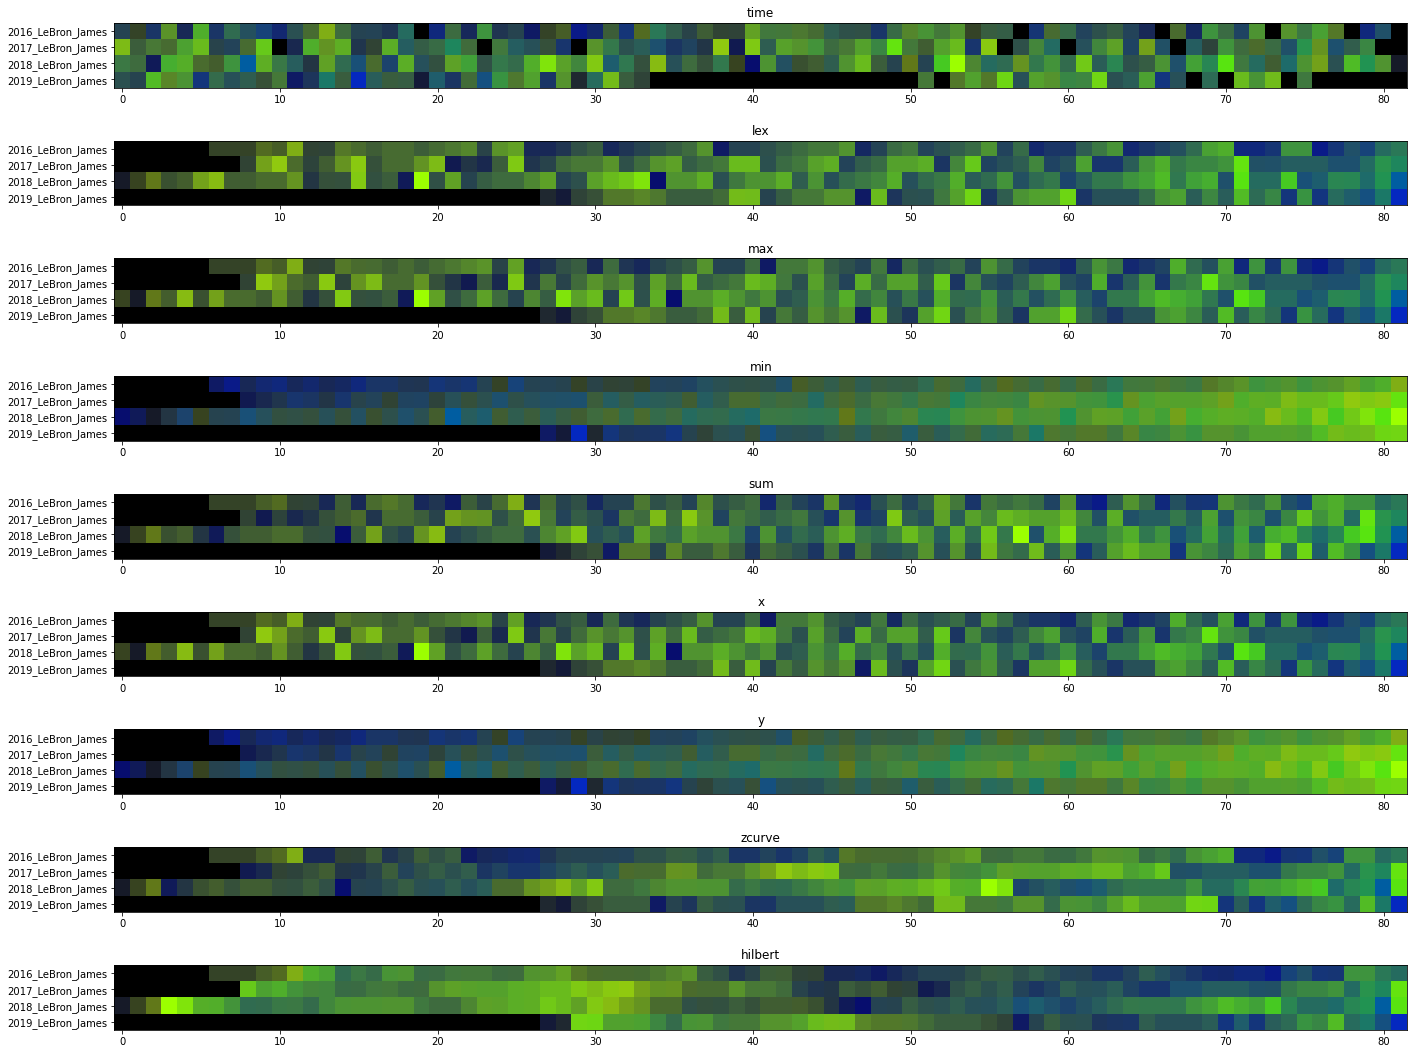

In [12]:
fig, ax = plt.subplots(9,1,figsize=(20,15))

plot_rug(test_rug, test_names, ax=ax[0],title='time')
plot_rug(build_rug(lex_matrix, max_x, max_y), test_names, ax=ax[1],title='lex')
plot_rug(build_rug(max_matrix, max_x, max_y), test_names, ax=ax[2],title='max')
plot_rug(build_rug(min_matrix, max_x, max_y), test_names, ax=ax[3],title='min')
plot_rug(build_rug(sum_matrix, max_x, max_y), test_names, ax=ax[4],title='sum')
plot_rug(build_rug(x_matrix, max_x, max_y), test_names, ax=ax[5],title='x')
plot_rug(build_rug(y_matrix, max_x, max_y), test_names, ax=ax[6],title='y')
plot_rug(build_rug(zcurve_matrix, max_x, max_y), test_names, ax=ax[7],title='zcurve')
plot_rug(build_rug(hilbert_matrix, max_x, max_y), test_names, ax=ax[8],title='hilbert')

fig.tight_layout(pad=2.0)
plt.show()

<a id='glyph_matrix'></a>
# Glyph matrix

In [9]:
import drawSvg as draw

C:\Users\linsp\miniconda3\envs\py-core\lib\site-packages\drawSvg\raster.py:18: RuntimeWarning: Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': error 0x7e
cannot load library 'libcairo.2.dylib': error 0x7e
cannot load library 'libcairo-2.dll': error 0x7e
  warnings.warn(msg, RuntimeWarning)


In [10]:
def get_player_data(player_df, feats):
    player_game_ids = list(player_df['game_id'])
    
    player_data = []
    
    for game_id in range(1,83):
        if game_id not in player_game_ids:
            player_data.append([0]*len(feats))
        else:
            player_game_id_data = [player_df[player_df.game_id == game_id][feat].values[0] for feat in feats]
            #player_game_id_data = []
            #for feat in feats:
            #    data = player_df[player_df.game_id == game_id][feat].values[0]
            #    player_game_id_data.append(data)
            player_data.append(player_game_id_data)
        
    return np.array(player_data)
    
    
def build_3d_player_matrix(data_path, feats, team=None, min_gp=0):
    player_matrix = []
    player_names  = []
    
    for fname in os.listdir(data_path):
        player_df = pd.read_csv(data_path+'/'+fname, sep='|')
        
        if player_df.shape[0] < min_gp:
            continue

        if team:
            if team not in player_df.team.values: continue
        
        player_names.append(fname)
        player_data = get_player_data(player_df, feats)
        
        player_matrix.append(player_data)
    
    player_matrix = np.array(player_matrix)   
    
    return player_matrix,player_names


In [11]:
def map_points(max_p, p, cell_width, cell_height, cell_center):
    x_p = 0
    y_p = (p*(cell_height/2))/max_p
    
    return cell_center[0]+x_p, cell_center[1]+y_p

def map_assists(max_a, a, cell_width, cell_height, cell_center):
    x_a = (a*(-cell_width/2))/max_a
    y_a = (a*(-cell_height/2))/max_a
    
    return cell_center[0]+x_a, cell_center[1]+y_a

def map_rebounds(max_r, r, cell_width, cell_height, cell_center):
    x_r = (r*(cell_width/2))/max_r
    y_r = (r*(-cell_height/2))/max_r
    
    return cell_center[0]+x_r, cell_center[1]+y_r

In [12]:
lbj, lbj_names = build_3d_player_matrix(r'../../data/NBA/test_matrix', ['points','assists','rebounds'])

In [13]:
lbj_10 = lbj[:,:20,:]
lbj_10.shape

(4, 20, 3)

In [14]:
def draw_glyph_matrix(data, width, height, cell_width, cell_height):
    max_p = np.max(data[:,:,0])
    max_a = np.max(data[:,:,1])
    max_r = np.max(data[:,:,2])

    canvas = draw.Drawing(width, height, origin=(0,0), displayInline=False)

    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            cell_center_x = (j*cell_width)+(cell_width/2)
            cell_center_y = (i*cell_height)+(cell_height/2)
            cell_center = [cell_center_x, cell_center_y]
            
            end = data.shape[0]-1
            p, a, r = data[end-i][j][0], data[end-i][j][1], data[end-i][j][2]

            x_p, y_p = map_points(max_p, p, cell_width, cell_height, cell_center)
            x_a, y_a = map_assists(max_a, a, cell_width, cell_height, cell_center)
            x_r, y_r = map_rebounds(max_r, r, cell_width, cell_height, cell_center)


            poly = draw.Lines(x_p, y_p,
                              x_a, y_a,
                              x_r, y_r,
                              close=True, fill="#0000FF55",
                              stroke="black")

            text_p = draw.Text(str(p), 10, cell_center[0]-5, y_p+5)
            text_a = draw.Text(str(a), 10, x_a, cell_center[1]-10)
            text_r = draw.Text(str(r), 10, x_r, cell_center[1]-10)

            canvas.append(poly)
            canvas.append(text_p)
            canvas.append(text_a)
            canvas.append(text_r)

    return canvas

In [15]:
width  = 1000
height = 200

cell_width  = 50
cell_height = 50

lbj10_glyph_matrix = draw_glyph_matrix(lbj_10, width, height, cell_width, cell_height)
lbj10_glyph_matrix

The above row represents the first 20 games of 4 LeBron James' seasons in the NBA, from 2015/16 (top) to 2018/19 (bottom). We can see that he is a very consistent scorer and missed very few games in the first quarter of each season. 

In [29]:
sp_matrix, _ = build_3d_player_matrix(r'../../data/NBA/sample_players', ['points','assists','rebounds'])
sp_matrix_20 = sp_matrix[:,:20,:]

sp_canvas = draw_glyph_matrix(sp_matrix_20, width, height, cell_width, cell_height)
sp_canvas

The glyph above represents the first 20 games of the following players in the 2018/19 season:

1. First Row &rarr; Andre Drummond
    
    Andre Drummond is a prolific scorer and rebounder, which we can see with most of his glyphs having a bigger top right edge. On the other side he does not have a good performance with assists, illustrated by a bottom right vertex very close to the center of each cell.


2. Second Row &rarr; Chris Paul

    Chris Paul is known for giving a lot of assists to his teammates, this can be observated by a pronunciated bottom right vertex in most of his glyphs. Unfortunately he is also known for being injury prone, we can see that he missed games 3 and 4 and another 3 games towards the end of the first quarter of the season.
    

3. Third Row &rarr; Klay Thompson

    Klay Thompson is a pure scorer, he starts the season in a normal pace but after having a game with 52 points he has a really good stretch scoring more than 20 points in most of his games. This hability to consistently put points is represented by glyphs with a high top vertex. He didn't miss any games in the first 20 but other than points he does not contribute a lot with assists and rebounds, given that he's more of a catch-and-shoot player.
    
    
4. Fourth Row &rarr; Russell Westbrook

    The last row represents Russel Westbrook, a player known for being a very consistent triple double threat. Unfortunately in this specific season he suffered with injury problems really early, missing some games in the first quarter of the season. Other than that his performance is often really consistent in every stat represented by the glyph having values close to the max in each vertex. The end of the first quarter of the season, though, appeared to be a good stretch with triple double in 3 of 4 games

In [56]:
p1 = [[10,7,3],[24,7,2],[8,5,5],[20,2,0],[12,6,4],[11,3,2],[9,3,2],[8,1,1],[30,4,5],[10,6,4]]
p2 = [[10,3,9],[13,4,6],[18,1,8],[23,4,7],[30,5,6],[20,3,7],[20,5,4],[15,3,7],[8,4,8],[2,0,1]]
p3 = [[25,10,6],[30,5,7],[42,13,10],[18,12,4],[10,3,2],[0,0,0],[0,0,0],[14,8,4],[23,11,5],[29,9,13]]
p4 = [[2,0,1],[4,3,0],[8,2,2],[3,4,2],[0,4,5],[7,5,2],[14,7,4],[16,8,7],[7,5,4],[4,0,2]]
datap = np.array([p1,p2,p3,p4])

pcanvas = draw_glyph_matrix(datap, 1000, 400, 100, 100)
pcanvas

In the above example we can see 4 different players (each row represents a player) with 4 different patterns each. 

* The first player is a player that puts up regular numbers (10-ish points per game and sub-10 assists and rebounds), but in some games this player had a surge of offensive power that made him put more than 20 points in these games, that is evidenced by triangles with more prominent top vertices.
* the second player is a player that in the first games has a tendency of increscing his number of points, as we can see in the top vertex going up as the other vertices don't change a lot. After peaking at 30 points in a game this player starts do decline his point production in the subsequent games, returning to his previous form and ending on a bad game.
* The third player is a star that puts up high number in every stat, playing near a triple double almost every game. For some reason (maybe a injury) his performance has a steep decline and he misses a few games before coming back and start increasing his stats again
* At the other end of the spectrum, player 4 is a bench player that either doesn't have enough opportunities or is not good. In some games he has a better performance but soon comes back to his old self.

# Tests and old code

In [67]:
import seaborn as sb
from hilbert import decode, encode

In [ ]:
data = [[[1,2,3,4,5],[6,7,8,9,10]],[[11,12,13,14,15],[16,17,18,19,20]]]

for a in data:
#     print(data[0],data[1])
    plt.plot(a[0],a[1])

In [ ]:
np.asarray(data).shape

In [ ]:
tt = np.random.randint(0,100,(10,2))

In [ ]:
sorted(tt, key=lambda x: (x[0],x[1]), reverse=False)

In [15]:
b = [[[1,7],[1,3]],[[5,8],[10,2]], [[20,5],[15,2]]]
b_s = sort_matrix_rows(b)

b, b_s

([[[1, 7], [1, 3]], [[5, 8], [10, 2]], [[20, 5], [15, 2]]],
 array([[[ 1,  3],
         [ 1,  7]],
 
        [[ 5,  8],
         [10,  2]],
 
        [[15,  2],
         [20,  5]]]))

In [16]:
[sorted(element, key=lambda x: sum(x), reverse=False) for element in b]

[[[1, 3], [1, 7]], [[10, 2], [5, 8]], [[15, 2], [20, 5]]]

In [ ]:
a = np.array([[[1,2],[7,8]], [[5,6],[11,12]], [[9,10],[3,4]]])
a_rows = sort_matrix_rows(a)
a_cols = sort_matrix_columns(a)

f, ax = plt.subplots(1,3,figsize=(5,5))

ax[0].imshow(build_rug(a,11,12))
ax[1].imshow(build_rug(a_rows,11,12))
ax[2].imshow(build_rug(a_cols,11,12))

plt.show()

In [ ]:
a, a.transpose((1,0,2))

In [ ]:
mx = np.array([[1,2],[3,4]])
mx.shape

In [ ]:
cmap_mx = [(1,0,0),(0,0,1),(0,1,0),(0,1,1)]

In [ ]:
sb.heatmap(mx,cmap=cmap_mx)

## Z-Curve stuff

In [ ]:
def get_lsb(num):
    little = num & 1
    return little

def get_z_idx(x,y):
    if x == 0 and y == 0:
        return 0
    
    bits = max(int(x).bit_length(), int(y).bit_length())

    bstr = ''
    
    while bits > 0:

        lsb_x = get_lsb(x)
        lsb_y = get_lsb(y)

        bstr = str(lsb_y) + str(lsb_x) + bstr 

        x = x >> 1
        y = y >> 1

        bits -= 1
    
    return int(bstr, 2)

In [ ]:
def zcurve(x,y):
    xx = x
    yy = y
    level = 0
    result = 0
    while xx > 0 or yy > 0:
        x_bit = 1 if (xx & 1) else 0
        y_bit = 1 if (yy & 1) else 0
        result += (x_bit + (y_bit << 1)) << (2*level)
        xx = xx >> 1
        yy = yy >> 1
        level += 1
    return result

def zcurve_inv(i):
    ii = i
    x = 0
    y = 0
    level = 0
    while ii > 0:
        x_bit = 1 if (ii & 1) else 0
        y_bit = 1 if (ii & 2) else 0
        x += x_bit << level
        y += y_bit << level
        level += 1
        ii = ii >> 2
    return (x,y)

def get_color_from_zidx(zidx):
    x, y = zcurve_inv(zidx)
    
    return get_color_from_coords(x,y)

In [ ]:
from scipy.cluster import hierarchy

Z = hierarchy.ward(spmatrix)
sorted_idxs = hierarchy.leaves_list(Z)
olo_sorted_1516 = []

for idx in sorted_idxs:
    olo_sorted_1516.append(pmatrix[idx])
olo_sorted_1516 = np.array(olo_sorted_1516)
plt.figure(figsize=(20,12))
plt.imshow(build_color_list(olo_sorted_1516), aspect='auto')

In [ ]:
from scipy.cluster import hierarchy

Z = hierarchy.ward(spmatrix)
sorted_idxs = hierarchy.leaves_list(Z)
olo_sorted_1516 = []

for idx in sorted_idxs:
    olo_sorted_1516.append(pmatrix[idx])
olo_sorted_1516 = np.array(olo_sorted_1516)
plt.figure(figsize=(20,12))
plt.imshow(build_color_list(olo_sorted_1516), aspect='auto')

In [ ]:
from scipy.cluster import hierarchy

b = np.array(sorted(zsorted_pmatrix, key=lambda x: sum(x), reverse=True))

# Z = hierarchy.ward(b)
# sorted_idxs = hierarchy.leaves_list(Z)
# sorted_values = []

# for idx in sorted_idxs:
#     sorted_values.append(b[idx])
# sorted_values = np.array(sorted_values)
plt.figure(figsize=(20,12))
plt.imshow(build_color_list(b), aspect='auto')

## Experiments with data matrix

* where each column was a game_id with the players sorted by their performance

### NBA

In [ ]:
def build_data_matrix(data_path):
    '''
        #param
            data_path: path containing elements data
            
        #returns
            3-d array with shape (82, N_PLAYERS, 2)
    '''
    player_matrix = []
    
    for fname in os.listdir(data_path):
        player_df = pd.read_csv(data_path+'/'+fname, sep='|')
        player_data = get_player_data(player_df)
        
        player_matrix.append(player_data)
    
    player_matrix = np.array(player_matrix)
#     print(player_matrix.shape)
    
    game_matrix = []
   
    for game in range(player_matrix.shape[1]):
        game_matrix.append([player[game] for player in player_matrix])
        
#     print(np.asarray(game_matrix).shape)
    
    return np.asarray(game_matrix)

In [ ]:
# data_matrix_9596 = build_data_matrix(r'../../data/NBA/nba_9596/nba_players_9596')
data_matrix_1516 = build_data_matrix(r'../../data/NBA/nba_1516/nba_players_1516')

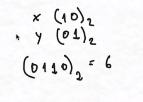

In [ ]:
data_matrix_1516.shape

In [ ]:
def build_curve_sorted_data_matrix(data_matrix, curve=['z','hilbert']):
    dmatrix_sorted = []

    for i in range(len(data_matrix)):
        if curve == 'z':
            col_with_zidxs = sorted([[obj, zcurve(obj[0],obj[1])] for obj in data_matrix[i]], key=lambda x: x[1], reverse=True)
        elif curve == 'hilbert':
            col_with_zidxs = sorted([[obj, encode(np.array([obj[0],obj[1]]),2,7)] for obj in data_matrix[i]], key=lambda x: x[1], reverse=True)
        
        col_clean      = np.array([obj[1] for obj in col_with_zidxs])
#         col_clean      = np.array([get_color_from_coords(obj[0][0],obj[0][1]) for obj in col_with_zidxs])
        dmatrix_sorted.append(col_clean)

    dmatrix_sorted = np.asarray(dmatrix_sorted)
    return dmatrix_sorted.transpose()


In [ ]:
dmatrix_z_1516 = build_curve_sorted_data_matrix(data_matrix_1516,'z')
# dmatrix_hilbert_1516 = build_curve_sorted_data_matrix(data_matrix_1516,'hilbert')

In [ ]:
plt.figure(figsize=(20,12))
plt.imshow(build_color_list(dmatrix_z_1516), aspect='auto')

In [ ]:
zsorted_pmatrix = build_curve_sorted_data_matrix(pmatrix,'z')
plt.figure(figsize=(20,12))
plt.imshow(build_color_list(zsorted_pmatrix), aspect='auto')

In [ ]:
plt.figure(figsize=(20,12))
sb.heatmap(dmatrix_z_1516,xticklabels=[],yticklabels=[],cmap=clist)
plt.show()

In [ ]:
f, axs = plt.subplots(2,1,figsize=(20,12))

sb.heatmap(dmatrix_z_1516,ax=axs[0],xticklabels=[],yticklabels=[],cmap=get_color_from_zidx)

sb.heatmap(dmatrix_hilbert_1516,ax=axs[1],xticklabels=[],yticklabels=[])

plt.show()

### COVID

In [ ]:
def build_cvd_data_matrix(data_path):
    '''
        data_path: path containing elements data
    '''
    loc_matrix = []
    
    for fname in os.listdir(data_path):
        loc_df = pd.read_csv(data_path+'/'+fname)
        loc_data = get_location_data_from_df(loc_df)
        
        loc_matrix.append(loc_data)
    
    loc_matrix = np.array(loc_matrix)
    
    date_matrix = []
   
    for date in range(loc_matrix.shape[1]):
        date_matrix.append([loc[date] for loc in loc_matrix])
            
    return np.asarray(date_matrix)

In [ ]:
data_matrix_cvd = build_cvd_data_matrix(r'../data/COVID/locations')
data_matrix_cvd.shape

In [ ]:
cvd_zsorted = build_zsorted_data_matrix(data_matrix_cvd)
cvd_zsorted.shape

In [ ]:
plt.figure(figsize=(20,15))
sb.heatmap(cvd_zsorted.transpose())
plt.show()